<a href="https://colab.research.google.com/github/1Steinthal/myrepo/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://cdn.iconscout.com/icon/free/png-256/twitter-87-432551.png" alt="drawing" width="32"/> Twitter sentiment analysis
This is a Python "R Markdown" (`JuPyter notebook`). You run each code block with `ctrl/cmd + enter` or by clicking the "play" arrow when you have selected the block. If you type `ctrl/cmd + shift + enter`, the focus will go to the next block. In Jupyter notebooks, text is also represented as a block. You can see menu options in the top to add "code" or "text".

Let us start by using the `!` to indicate that we are doing something in the **terminal** from within this file (since we cannot access the terminal). This terminal action uses `pip` which is a package for managing packages (woah). Here, we make sure that [`vaderSentiment`](https://github.com/cjhutto/vaderSentiment#:~:text=Notifications-,VADER%20Sentiment%20Analysis.,on%20texts%20from%20other%20domains.), [`sentida`](https://github.com/Guscode/Sentida) and [`tweepy`](https://www.tweepy.org/) are installed:

In [ ]:
!pip install sentida
!pip install tweepy
!pip install vaderSentiment
!pip install pandas

     |████████████████████████████████| 64 kB 2.8 MB/s 
  Created wheel for sentida: filename=sentida-0.6.0-py3-none-any.whl size=61681 sha256=0243f836c3b2b2d6808f739dd4a3f740a23c5a18e08bff1cf940386db7e9a94e
  Stored in directory: /root/.cache/pip/wheels/5b/f8/65/979fac25993c9028d89d60364b0ade0456fdb81bc48a60272e
Successfully built sentida
     |████████████████████████████████| 125 kB 16.2 MB/s 


Then we import our libraries just like in `R`. Instead of using `library`, we just use the `import` verb instead. When we write `as tw` or `as pd`, we can refer to the package by the shorter name instead of writing the long name each time (nice).

In [ ]:
from sentida import Sentida as s
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as v
import tweepy as tw
import pandas as pd

Then we set up our Twitter access. These API keys are **SUPER** secret, but here you go 😘 From me to you, my hyper-secret access keys.

## What do I get access to???
With these keys, Tweepy can access an **app** created by a **user** with a **developer account**. In this case, the app is called `SentChecker`, it is created by me [`esbenkc`](https://twitter.com/esbenkc) and is part of the standard access that gives us the ability to download up to **500,000** tweets per month.

## 😥 What are we to do with that little data, Esben?
Well, I encourage you to set up your own developer accounts so you can create your own apps as well for more Twitter action! This will be a small test so you can see how easy it is to set up and then we will import a **big dataset** for our analyses...

In [ ]:
# Your Twitter API key and API secret
my_api_key = "FJL5ZphG37uM1StxgiofFkR7p"
my_api_secret = "Un4gXd6q1FOJaGyLfThgk3GpIP1HbcROEd6TBGVim8AdsumrE3"

# Authenticate
auth = tw.OAuthHandler(my_api_key, my_api_secret)
api = tw.API(auth, wait_on_rate_limit=True)

Now we define a search term just like you would if you searched something on Twitter. In this case, we search for `covid19` hashtags and remove all retweets `-filter:retweets` since they will be duplicates in our data. We then search and pull down some tweets!

In [ ]:
search_query = "#covid19 -filter:retweets"

# Get 10 tweets from the API (remember, the app can only take 500,000 tweets, 
# so don't change the number too high or your fellow students won't have access 💘)
tweets = tw.Cursor(api.search,
              q=search_query,
              lang="en",
              since="2021-09-16").items(10)

# Store the API responses in a list using a for loop
tweets_copy = []
for tweet in tweets:
    tweets_copy.append(tweet)

print("Total Tweets fetched:", len(tweets_copy))
tweets

Total Tweets fetched: 10


But the tweets come in a so-called `dictionary` format (or `json`, `object`, etc...) that we have to convert into our beloved `dataframe` format. `Pandas` (here = `pd`) is like the `tidyverse` of Python but a bit more messy.

A dictionary/json looks like this: 

![JSON example](https://static.goanywhere.com/images/tutorials/read-json/ExampleJSON2.png)

You can see how we have `[]` to represent a list (in this case, it has just one item) and we have `{}` to represent different named variables, e.g. `orderno`, `date`, etc. Their values are then given by a `:`. Nearly all data on the internet looks like this but it's hard to do data analysis on, so we convert it like so and get a dataframe:

In [ ]:
# Create an empty dataframe
tweets_df = pd.DataFrame()

# populate the dataframe
for tweet in tweets_copy:
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    tweets_df = tweets_df.append(pd.DataFrame({'user_name': tweet.user.name, 
                                               'user_location': tweet.user.location,\
                                               'user_description': tweet.user.description,
                                               'user_verified': tweet.user.verified,
                                               'date': tweet.created_at,
                                               'text': text, 
                                               'hashtags': [hashtags if hashtags else None],
                                               'source': tweet.source}))
    tweets_df = tweets_df.reset_index(drop=True)

# show the dataframe
tweets_df.head()

,user_name,user_location,user_description,user_verified,date,text,hashtags,source
0,Bella Cherie,United States,Jesus Christ is God. The Word of God says you ...,False,2021-11-09 12:18:20,@Reuters #WARNING A TSUNAMI WILL HIT THE EAST ...,[WARNING],Twitter Web App
1,Keith Pompey,OnTheGoFlow,.@Sixers beat writer for @PhillyInquirer/ @pro...,True,2021-11-09 12:18:18,How will Joel Embiid’s absence due to testing ...,None,Twitter Web App
2,Care Home Pro,United Kingdom,"News, insight and intelligence for #carehome o...",False,2021-11-09 12:18:10,BREAKING NEWS: Care home #COVID19 deaths rise ...,[COVID19],Twitter Web App
3,Bella Cherie,United States,Jesus Christ is God. The Word of God says you ...,False,2021-11-09 12:18:09,@thehill #WARNING A TSUNAMI WILL HIT THE EAST ...,[WARNING],Twitter Web App
4,🌴🍍𝙇𝖚𝙘𝖆𝙨🍍🌴™,in heaven #RIP,Colts Fan #WeBelieve ➤ Public Figure ➤ Big Dab...,False,2021-11-09 12:18:09,#WARNING A TSUNAMI WILL HIT THE EAST COAST!! L...,[WARNING],Twitter for Android


# Amazing! You're now a Twitter Wiz 🧙🏼‍♂️
## Let's start some sentiment analysis!

Now let's load in some real big data from another user who has already done the above query for 179,107 tweets! With `pd.read_csv()` (remember `pd = pandas`), we can load a dataset directly from a link to the file (you can click on the link with `ctrl/command + click` to check out the raw data. This is a CSV so we don't have to do anything weird to make it into a dataframe.

In [ ]:
loaded_df = pd.read_csv("https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv")
print("Loaded", len(loaded_df)-1, "tweets.")
loaded_df.head(5)

Loaded 179107 tweets.


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


We can see that we get the following columns:
- user_name: The user's name (`esbenkc`)
- user_location: The user's written location (`Aarhus`)
- user_description: User's description
- user_created: When the user was created
- user_followers: How many followers the user has
- user_friends: How many "friends" (people the user is following) the user has
- user_favourites: How many likes the user's tweets has
- user_verified: If the user is verified (e.g. `elonmusk` with the little checkmark besides his name)
- date: The tweet's post date
- text: The content of the tweet
- hashtags: Which hashtags are in the text (`NaN` if there are none)
- source: Which device the user created the tweet with
- is_retweet: If it is a retweet (there should be none because we filtered them

## 😂😣 Sentiment analysis
Now we want to perform sentiment analysis on the text. We are going to use the wonderful library `vader` to do this really easily but normally, we could use the following process:
1. Remove all weird characters from the text, e.g. links and hashtags, etc. using [`regex`](https://www.computerhope.com/jargon/r/regex.htm)
2. Separate the `text` column so we get a row for each word in that column using something like `text_column.split("\W")` which splits it by any character that isn't a letter. This is a _very_ simple implementation of the so-called `tokenization` that splits a text into `tokens`.
3. Compare each word to a dictionary with a sentiment value associated to each word (negative to positive).

Luckily, `vader` does all this work for us and more. I developed the `sentida` package for Danish sentiment analysis if you want to use your own Danish Twitter search. Let's try them both out!

In [ ]:
print("Jeg elsker fisk, men jeg hader mageritter! on sentida unnormal:", s().sentida("Jeg elsker fisk, men jeg hader mageritter!", normal=True),
      "\nJeg elsker fisk! on sentida:", s().sentida("Jeg elsker fisk!"),
      "\nJeg hader fisk! on sentida:", s().sentida("Jeg hader fisk!"),
      "\nI love fish on vader:", v().polarity_scores("I love fish."),
      "\nI love fish! on vader:", v().polarity_scores("I love fish!"),
      "\nI hate fish! on vader:", v().polarity_scores("I hate fish!"), "compound only:", v().polarity_scores("I hate fish!")['compound'])

Jeg elsker fisk, men jeg hader mageritter! on sentida unnormal: -0.1601442500000002 
Jeg elsker fisk! on sentida: 1.0 
Jeg hader fisk! on sentida: -1.0 
I love fish on vader: {'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369} 
I love fish! on vader: {'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696} 
I hate fish! on vader: {'neg': 0.666, 'neu': 0.334, 'pos': 0.0, 'compound': -0.6114} compound only: -0.6114


**What do we see from this output?**

- Sentida just returns one value which goes from -1 to 1 while Vader returns a little dictionary (*oh, we know what that is!*) that we can access with `['compound']` to get sort of the same representation as Sentida gives.
- That `!` modulates how much sentiment there is (*hmmm, maybe other things also modulate the sentiment?*).
- That Sentida is for Danish what Vader is for English

## Let's go on to analyse our dataset
We assign a new list of sentiments for each tweet in `tweet_df['text']` to a new column with Vader (since this dataset is English). Here, I use two different ways to write a loop: 1) a `for loop` and 2) a so-called `list comprehension`. List comprehensions are a very Python thing and reduce the code length quite a bit.

It takes a bit of time to run so we grab a subset of the data (1,000 rows).

In [ ]:
subset_df = loaded_df.sample(1000)

# Using a for loop (commented because it takes quite a while to run):

# sentiments = []
# for tweet in subset_df['text']:
#   sentiments.append(
#       v().polarity_scores(tweet)['compound']
#   )
# subset_df['sentiment'] = sentiments

# This one does the same as the above and is slightly faster:
subset_df['sentiment'] = \
  [v().polarity_scores(tweet)['compound'] for tweet in subset_df['text']]

[print("\n\nSentiment:", row[1][13], "\nText:\n", row[1][9]) for row in subset_df.head(5).iterrows()]



Sentiment: -0.7906 
Text:
 European countries rushed to house the homeless during the coronavirus crisis. Advocates worry the changes won’t la… https://t.co/Rnud7Zy61w


Sentiment: 0.4515 
Text:
 Any #highered #mathematics profs out there willing to give this a go or give credit to Grad students? Undergrad? To… https://t.co/KH8cj2h0wb


Sentiment: 0.0 
Text:
 It really should be the parents choice to send children back to school. Not the president or a school district.… https://t.co/2STWphf5Ro


Sentiment: 0.4576 
Text:
 Screenshots I personally took of the NIH Pub Med website showing a very interesting paper that was about to be publ… https://t.co/XjCmky6R4R


Sentiment: 0.0 
Text:
 This story was published on https://t.co/Qeh1F0X78X

#covid #covid19 #antibody https://t.co/Islfn540hS


[None, None, None, None, None]

## 👩🏼‍🔬 Doing science!
- # What do we notice? 

### Let's try plotting the data using Python
Some classic Python visualization packages are: [`Plotly`](https://plotly.com/python/) that generates wonderful interactive visualizations, [`matplotlib`](https://matplotlib.org/stable/tutorials/introductory/pyplot.html) which is horrible but which everyone uses for some reason, [`Seaborn`](https://seaborn.pydata.org/introduction.html) which is quite easy and neat.

`pandas` already includes some very basic plotting functionality that is built on top of `matplotlib`. Check out the [documentation](https://pandas.pydata.org/docs/user_guide/visualization.html).

- # What might our hypotheses be?
  - Import S&P500 market and see correlation with sentiment of global/US/cult members for Elono mUsko users
  - News sentiment dataset correlated with Twitter sentiment dataset
  - Weekdates' / times' correlation with sentiment
  - Holidays affect sentiment: Christmas
  - Correlation between covid local deaths and local twitter sentiment
  - Public intellectuals' influence on the sentiment: Segregate people with high following and low following
  - Global death count vs. sentiment
  - Desentisized: Over time, lesser negativity with every subsequent spike
  - Does it have effect on being antivaxxer from using iPhone vs. Android?
  - Compare across countries with different strategies: Oxford Covid Stringency Dataset
  - Sentiment change on vaccine change

- # What do we want to plot?

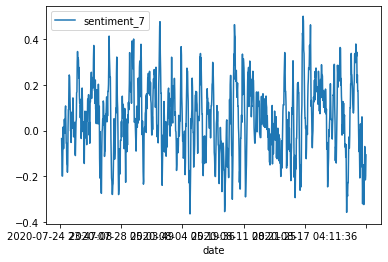

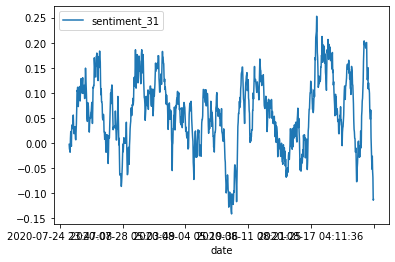

In [ ]:
# subset_df.plot(x="date", y="sentiment")
subset_df = subset_df.sort_values('date')
subset_df['sentiment_7'] = subset_df.rolling(window=7)['sentiment'].mean()
subset_df['sentiment_31'] = subset_df.rolling(window=31)['sentiment'].mean()
# subset_df.tail(2)
subset_df.plot(x="date", y="sentiment_7")
subset_df.plot(x="date", y="sentiment_31")

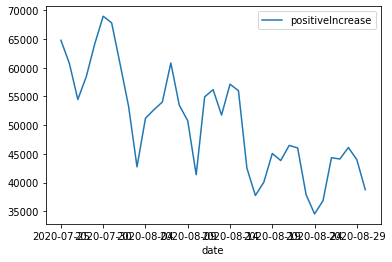

In [ ]:
# # Compare to covid numbers in US
covid_df = pd.read_csv("https://covidtracking.com/data/download/national-history.csv")

covid_df = covid_df.sort_values('date')
# covid_df['death_31'] = covid_df.rolling(window=31)['death'].mean()
covid_df = covid_df[(min(subset_df['date']) < covid_df['date']) & (covid_df['date'] < max(subset_df['date']))]
covid_df.plot(x='date', y='positiveIncrease')

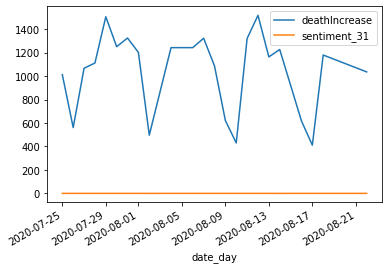

In [ ]:
# subset_df['date_day'] = pd.to_datetime(subset_df['date']).dt.date
# covid_df['date_day'] = pd.to_datetime(covid_df['date']).dt.date
# plot_df = pd.merge(subset_df, covid_df, on="date_day", how="inner")
# plot_df['date_day'] = pd.to_datetime(plot_df['date_day'])
# plot_df = plot_df.groupby(plot_df['date_day'].dt.day).agg({'date_day':'first',
#                                                  'deathIncrease':'first',
#                                                  'sentiment_31':'mean'})
# plot_df.plot(x="date_day", y=["deathIncrease", "sentiment_31"])

# plot_multi(plot_df, y=['deathIncrease', 'sentiment_31'], x='date_day')

Bonus:

Try to make your own graphs about your own hypotheses, e.g. if people from specific places are generally more negative 🤔

# Awesome inspiration
My wonderful partner Maris created some plots for our Prime Minister about the coronavirus response from the Danish population. [Check them out](https://github.com/centre-for-humanities-computing/hope-vaccines-twitter):

![sentmient over time](https://github.com/centre-for-humanities-computing/hope-vaccines-twitter/raw/master/fig/sentiment_compound_mentions_count_labelled.png)
![sentment over time](https://github.com/centre-for-humanities-computing/hope-vaccines-twitter/raw/master/fig/sentiment_compound_entropy_labelled.png)